<a href="https://colab.research.google.com/github/maytlim/doh_data/blob/main/labresults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import re
import pandas as pd
import datetime
import gdown
import matplotlib.pyplot as plt

In [2]:
try:
  import pdfx
except ModuleNotFoundError:
  !pip -q install pdfx
  import pdfx

     |████████████████████████████████| 5.6 MB 27.9 MB/s 
     |████████████████████████████████| 178 kB 42.6 MB/s 
     |████████████████████████████████| 3.2 MB 54.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires chardet<4,>=3.0.2, but you have chardet 4.0.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
#Code from https://gist.github.com/korakot/51a917e1f53891d53be223439b0f75c1
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  #gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

'''list all ids and filenames of files directly under folder folder_id'''
def folder_list_named(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [[f['id'], f['name']] for f in res['files']]

'''download specific file from a gdrive folder to current directory'''
def folder_download_specific(folder_id, search_term):
  for fid, fname in folder_list_named(folder_id):
    found = re.search(search_term, fname)
    if found:
      !gdown -q --id $fid

In [4]:
def folder_list_test(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  for f in res['files']:
    print(f)
  return [f['id'] for f in res['files']]

In [5]:
ddrop_readme = requests.get('http://bit.ly/DataDropPH').url
ddrop_readme = ddrop_readme.split('/')[-1].split('?')[0]
#print(ddrop_readme)
!rm *.pdf #remove existing pdf file before downloading 
folder_download(ddrop_readme)

rm: cannot remove '*.pdf': No such file or directory


In [6]:
readme_pdf = !ls *.pdf
readme_pdf = readme_pdf[0][1:-1]
readme_pdf
pdfx_tmp = pdfx.PDFx(readme_pdf)
ddlinks = pdfx_tmp.get_references_as_dict()

In [7]:
month_day = readme_pdf.split('_')
month = int(month_day[0][-2:])
day = int(month_day[1][:2])
month, day
year = 2021
print('DOH DataDrop Release:', year, month, day)

DOH DataDrop Release: 2021 8 23


In [8]:
search_term = 'Testing Aggregates'
downloaded = False
for ddlink in ddlinks['url']:
  if downloaded == False:
    if ddlink[:15] == 'https://bit.ly/' and ddlink[-3:] != 'ive':
      datadrop = requests.get(ddlink).url
      datadrop = datadrop.split('/')[-1].split('?')[0]
      #folder_download(datadrop)
      folder_download_specific(datadrop, search_term)
      print(search_term, '... downloaded')
      downloaded = True
  else:
    continue

Testing Aggregates ... downloaded


In [9]:
data_date = datetime.datetime(year, month, day)
#data_dir ='DOH COVID Data Drop_'  + data_date.strftime('%Y%m%d') + '/'

In [10]:
# testing aggregates - reporting labs
labs_filename = 'DOH COVID Data Drop_ ' + data_date.strftime('%Y%m%d') + ' - 07 Testing Aggregates.csv'
print('testing labs report:', labs_filename)

testing labs report: DOH COVID Data Drop_ 20210823 - 07 Testing Aggregates.csv


In [11]:
df_labs = pd.read_csv(labs_filename)
df_labs.keys()
date_labels = ['report_date']
for label in date_labels:
  df_labs[label] = pd.to_datetime(df_labs[label])

In [12]:
reg_lookup = {'ROF': 'ROF', 'NCR': 'NCR', 'BARMM': 'BARMM', 'CAR': 'CAR', 
              'I': 'Region I: Ilocos Region', 'II': 'Region II: Cagayan Valley', 'III': 'Region III: Central Luzon', 'IV-A': 'Region IV-A: CALABARZON',
              'IV-B': 'Region IV-B: MIMAROPA', 'V': 'Region V: Bicol Region', 'VI': 'Region VI: Western Visayas', 'VII': 'Region VII: Central Visayas',
              'VIII': 'Region VIII: Eastern Visayas', 'IX': 'Region IX: Zamboanga Peninsula', 'X': 'Region X: Northern Mindanao', 
              'XI': 'Region XI: Davao Region', 'XII': 'Region XII: SOCCSKSARGEN', 'XIII': 'CARAGA'}

def filter_condition(df, condition, by='RegionRes'):
  filter = df[by] == condition
  df_filtered = df[filter]
  return df_filtered

In [13]:
!gdown -q 'https://raw.githubusercontent.com/maytlim/doh_data/main/nhfr.json'
nhfr = pd.read_json('nhfr.json')

In [14]:
#grab the region and province of the testing labs from the the NHFR (https://nhfr.doh.gov.ph/)
lab_addy = nhfr[['Health Facility Code', 'Region Name', 'Province Name']]

In [15]:
#Testing Aggregates.csv file does not contain the lab hfhudcodes -- this part is a workaround
#Kludge: when the lab name does not appear in the NHFR, manually find the address and use an hfhudcode of a facility in the same city
#In labslist.xls, these labs appear with an hfhudcode but no nhfr_name
#To do: Encode the listing from the DOH daily report
!curl -O 'https://raw.githubusercontent.com/maytlim/doh_data/main/labslist.xls'
lab_list = pd.read_excel('labslist.xls')
lab_list = lab_list.merge(how='left', right=lab_addy, left_on='hfhudcode', right_on='Health Facility Code')
lab_list.drop(['hfhudcode', 'short_code', 'Health Facility Code', 'nhfr_name'], axis=1, inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64512  100 64512    0     0   533k      0 --:--:-- --:--:-- --:--:--  533k


In [16]:
df_labs = df_labs.merge(how='left', right=lab_list, left_on='facility_name', right_on='lab_name')

In [17]:
reg_lookup = {'NCR': 'NATIONAL CAPITAL REGION (NCR)',  
              'CAR': 'CORDILLERA ADMINISTRA TIVE REGION (CAR)', 'I': 'REGION I (ILOCOS REGION)', 
              'II': 'REGION II (CAGAYAN VALLEY)', 'III': 'REGION III (CENTRAL LUZON)', 
              'IV-A': 'REGION IV-A (CALABAR ZON)', 'IV-B': 'REGION IV-B (MIMAROPA)', 
              'V': 'REGION V (BICOL REGION)', 'VI': 'REGION VI (WESTERN VISAYAS)', 
              'VII': 'REGION VII (CENTRAL VISAYAS)', 'VIII': 'REGION VIII (EASTERN VISAYAS)', 
              'IX': 'REGION IX (ZAMBOANGA PENINSULA)', 'X': 'REGION X (NORTHERN MINDANAO)', 
              'XI': 'REGION XI (DAVAO REGION)', 'XII': 'REGION XII (SOCCSKSA RGEN)', 
              'XIII': 'REGION XIII (CARAGA)', 'BARMM': 'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)'}

In [18]:
df_results = df_labs.groupby(['Region Name', 'report_date']).sum()[['daily_output_unique_individuals', 'daily_output_positive_individuals']]
df_results['daily_positivity'] = df_results['daily_output_positive_individuals'] / df_results['daily_output_unique_individuals']
df_plot = df_results['daily_positivity'].unstack(level=0)

In [19]:
start_date = datetime.datetime(2021, 1, 1)
#end_date = datetime.datetime.today()
filter = (df_plot.index >= start_date)
df_plot = df_plot[filter]

In [20]:
df_tests = df_results['daily_output_unique_individuals'].unstack(level=0)

start_date = datetime.datetime(2021, 1, 1)
#end_date = datetime.datetime.today()
filter = (df_tests.index >= start_date)
df_tests = df_tests[filter]

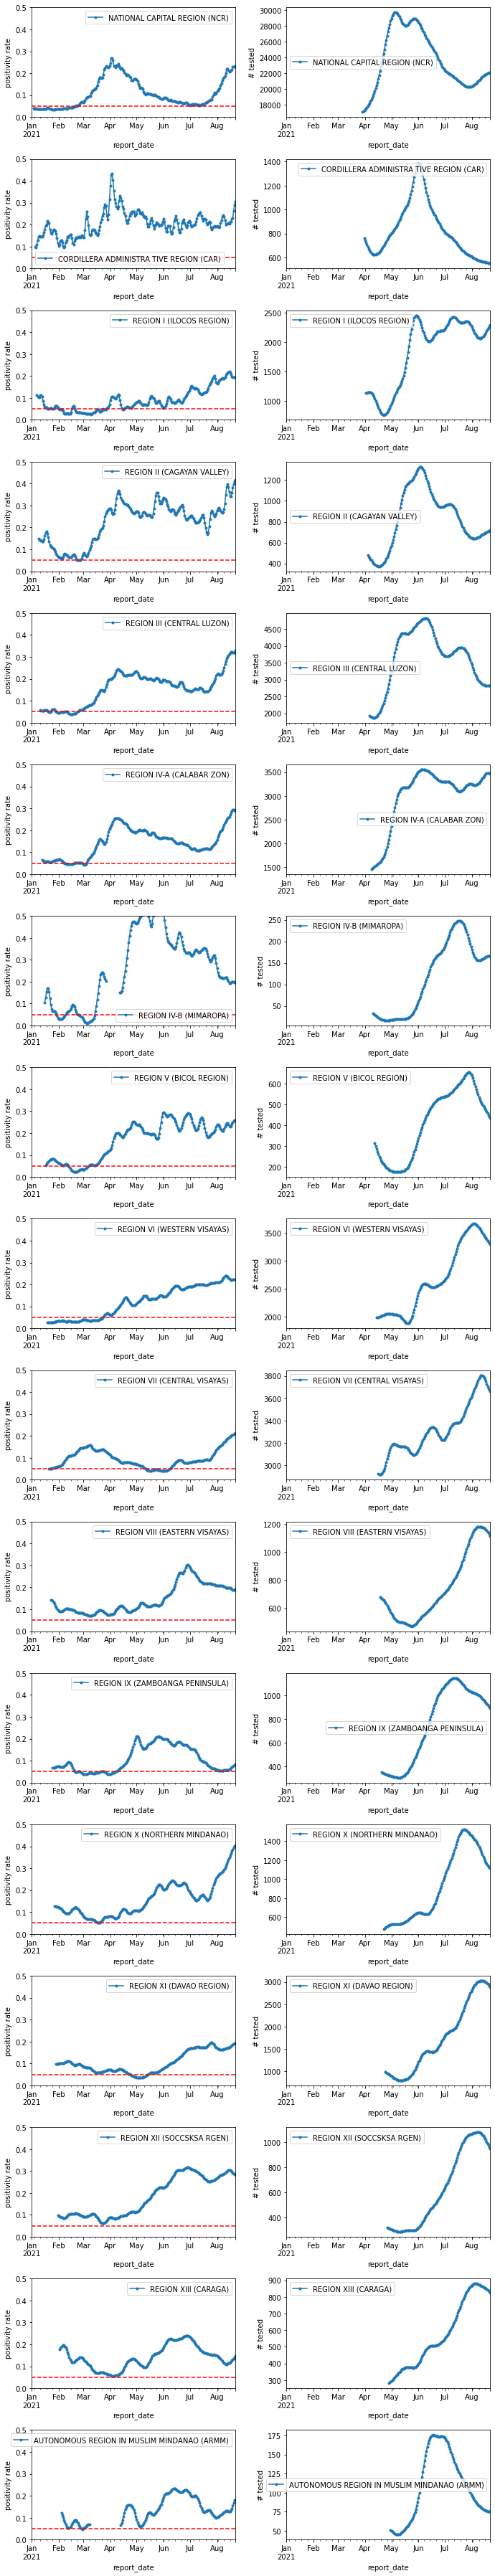

In [28]:
dma = 3
fig, axes = plt.subplots(nrows=len(reg_lookup), ncols=2, sharex=False, figsize=(10, 50))
#fig.subplots_adjust(hspace=0.5)
for i, reg in enumerate(reg_lookup):
  df_plot = df_plot.rolling(window=dma).mean()
  df_plot[reg_lookup[reg]].plot(ax=axes[i][0], ylim=[0,0.5], legend=True, ylabel='positivity rate', marker='.')
  l2=axes[i][0].axhline(0.05,color='red',ls='--')
  df_tests = df_tests.rolling(window=dma).mean()
  df_tests[reg_lookup[reg]].plot(ax=axes[i][1], legend=True, ylabel='# tested', marker='.')
fig.tight_layout()

In [22]:
df_labs.keys()

Index(['facility_name', 'report_date', 'avg_turnaround_time',
       'daily_output_samples_tested', 'daily_output_unique_individuals',
       'daily_output_positive_individuals',
       'daily_output_negative_individuals', 'daily_output_equivocal',
       'daily_output_invalid', 'remaining_available_tests', 'backlogs',
       'cumulative_samples_tested', 'cumulative_unique_individuals',
       'cumulative_positive_individuals', 'cumulative_negative_individuals',
       'pct_positive_cumulative', 'pct_negative_cumulative',
       'validation_status', 'lab_name', 'Region Name', 'Province Name'],
      dtype='object')

In [23]:
df_labs[df_labs['facility_name'] == 'UP Philippine Genome Center'].tail(8)

,facility_name,report_date,avg_turnaround_time,daily_output_samples_tested,daily_output_unique_individuals,daily_output_positive_individuals,daily_output_negative_individuals,daily_output_equivocal,daily_output_invalid,remaining_available_tests,backlogs,cumulative_samples_tested,cumulative_unique_individuals,cumulative_positive_individuals,cumulative_negative_individuals,pct_positive_cumulative,pct_negative_cumulative,validation_status,lab_name,Region Name,Province Name
74523,UP Philippine Genome Center,2021-08-15,48.0,0.0,0.0,0.0,0.0,0.0,0.0,2332.0,0.0,82224,81802,17319,64483,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74524,UP Philippine Genome Center,2021-08-16,48.0,0.0,0.0,0.0,0.0,0.0,0.0,2332.0,0.0,82224,81802,17319,64483,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74525,UP Philippine Genome Center,2021-08-17,48.0,382.0,382.0,186.0,196.0,0.0,0.0,1950.0,0.0,82606,82184,17505,64679,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74526,UP Philippine Genome Center,2021-08-18,48.0,548.0,548.0,138.0,410.0,0.0,0.0,0.0,0.0,83154,82732,17643,65089,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74527,UP Philippine Genome Center,2021-08-19,48.0,419.0,419.0,164.0,255.0,0.0,0.0,14000.0,0.0,83573,83151,17807,65344,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74528,UP Philippine Genome Center,2021-08-20,48.0,48.0,58.0,0.0,58.0,0.0,0.0,13942.0,0.0,83621,83209,17807,65402,0.21,0.79,For Review,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74529,UP Philippine Genome Center,2021-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83621,83209,17807,65402,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
74530,UP Philippine Genome Center,2021-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83621,83209,17807,65402,0.21,0.79,NaN,UP Philippine Genome Center,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (Not a Province)"
